# Text Cleaning

In [1]:
import nltk, re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
 
def spell_correct(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\0s", "0", text)    
    return text
 
def remove_url(text):
    URL_REGEX = re.compile(r'''((http[s]?://)[^ <>'"{}|\\^`[\]]*)''')
    return URL_REGEX.sub(r' ', text)
 
remove_punc = lambda x : re.sub(r"\W", ' ', x)
 
remove_num = lambda x : re.sub(r"\d", ' ', x)
 
remove_extra_spaces = lambda x : re.sub(r"\s+", ' ', x)
 
lower_case = lambda x : x.lower()
 
with open('stopwords.txt') as f:
    sw = map(lambda x : x.strip(), f.readlines())
stop_words = set(nltk.corpus.stopwords.words('english'))|set(sw)
remove_stopwords = lambda x: ' '.join(word for word in x.split() if word not in stop_words)
 
ps = PorterStemmer()
ps_stem = lambda x: ' '.join(ps.stem(word) for word in x.split())
 
wnl = WordNetLemmatizer()
wnl_lemmatize = lambda x: ' '.join(wnl.lemmatize(word) for word in x.split())
 
def tag_pos(x):
    tag_list =  nltk.pos_tag(nltk.word_tokenize(x))
    pos = ""
    for t in tag_list:
        pos += t[0] +'(' + t[1] +')' + ' '
    return pos
 
def cleanText(x, rsw, stm, lem, tgps):
    x = str(x)
    x = remove_url(x)
    x = lower_case(x)
    x = spell_correct(x)
    x = remove_punc(x)
    x = remove_num(x)
    x = remove_extra_spaces(x)
   
    if rsw:
        x = remove_stopwords(x)
    if stm:
        x = ps_stem(x)
    if lem:
        x = wnl_lemmatize(x)
    if tgps:
        x = tag_pos(x)
    return x

# Various Similarity Metrics

## Jaccard Similarity:
Jaccard similarity or intersection over union is defined as size of intersection divided by size of union of two sets.

In [2]:
def jaccard_sim(str1, str2):
    a = set(cleanText(str1, True, False, True, False).split())
    b = set(cleanText(str2, True, False, True, False).split())
    c = a & b
    d = a | b
    return float(len(c)) / (len(d))*100

In [3]:
jaccard_sim('AI is our friend and it has been friendly', 'AI and humans have always been friendly')

50.0

## Cosine Similarity:
Cosine similarity calculates similarity by measuring the cosine of angle between two vectors.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
 
def cosine_sim(str1, str2):
    str_ = [cleanText(str1, True, False, True, False), cleanText(str2, True, False, True, False)]
    vectorizer = CountVectorizer()
    vect_ = vectorizer.fit_transform(str_).toarray()
    return cosine_similarity([vect_[0]], [vect_[1]])[0][0]*100
 

In [5]:
cosine_sim('AI is our friend and it has been friendly', 'AI and humans have always been friendly')

66.66666666666669

## Fuzzy String Matching
Fuzzy string matching is the technique of finding strings that match a pattern approximately (rather than exactly). In another word, fuzzy string matching is a type of search that will find matches even when users misspell words or enter only partial words for the search. It is also known as approximate string matching.

In [6]:
from fuzzywuzzy import fuzz

D:\Users\Ritvik\Anaconda3\envs\datascience\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Ratio
ratio compares the entire string similarity, in order

In [7]:
def fuzz_ratio(str1, str2):
    return fuzz.ratio(cleanText(str1, True, False, True, False),
                      cleanText(str2, True, False, True, False))

In [8]:
fuzz_ratio('AI is our friend and it has been friendly', 'AI and humans have always been friendly')

74

### Partial Ratio
partial_ratio compares partial string similarity

In [9]:
def fuzz_partial_ratio(str1, str2):
    return fuzz.partial_ratio(cleanText(str1, True, False, True, False),
                              cleanText(str2, True, False, True, False))

In [10]:
fuzz_partial_ratio('AI is our friend and it has been friendly', 'AI and humans have always been friendly')

71

### Token Sort Ratio
token_sort_ratio ignores word order

In [11]:
def fuzz_token_sort_ratio(str1, str2):
    return fuzz.token_sort_ratio(cleanText(str1, True, False, True, False),
                              cleanText(str2, True, False, True, False))

In [12]:
fuzz_token_sort_ratio('AI is our friend and it has been friendly', 'AI and humans have always been friendly')

63

### Token Set Ratio
token_set_ratio ignores duplicated words

In [13]:
def fuzz_token_set_ratio(str1, str2):
    return fuzz.token_sort_ratio(cleanText(str1, True, False, True, False),
                              cleanText(str2, True, False, True, False))

In [14]:
fuzz_token_set_ratio('AI is our friend and it has been friendly', 'AI and humans have always been friendly')

63

## Removing and Matching Synonyms

In [15]:
from nltk.corpus import wordnet
 
def compute_synonyms(x):
    synonyms_list = [x]
    for syn in wordnet.synsets(x):
        for s in syn.lemmas():
            synonyms_list.append(s.name())
    return set(synonyms_list)
 
def remove_synonyms(str_):
    words = cleanText(str_, True, False, True, False).split()
    synonyms = set()
    reduced_words = set()
    for w in words:
        flag = 0
        syns = compute_synonyms(w)
        for s in syns:
            if s in synonyms:
                flag = 1
                break
        synonyms = synonyms | syns
        if flag == 0:
            reduced_words = reduced_words|set([w])
    return reduced_words

### Jaccard Similarity

In [16]:
def jaccard_sim_syn(str1, str2):
    a = remove_synonyms(str1)
    b = remove_synonyms(str2)
    c = 0
    for w in a:
        syns = compute_synonyms(w)
        for s in syns:
            if s in b:
                c += 1
    return float(c / (len(a)+len(b)-c))*100

In [17]:
jaccard_sim_syn('AI is our friend and it has been friendly', 'AI and humans have always been friendly')

50.0

## Similarity Metrics Using WordNet

In [18]:
from nltk.corpus import wordnet as wn
from nltk import pos_tag

In [19]:
def penn_to_wn(tag):
    """ Convert between a Penn Treebank tag to a simplified Wordnet tag """
    if tag.startswith('N'):
        return 'n'
    if tag.startswith('V'):
        return 'v'
    if tag.startswith('J'):
        return 'a'
    if tag.startswith('R'):
        return 'r'
    return None
 
def tagged_to_synset(word, tag):
    wn_tag = penn_to_wn(tag)
    if wn_tag is None:
        return None
    try:
        return wn.synsets(word, wn_tag)[0]
    except:
        return None
    
def sim_wordnet(sentence1, sentence2):
    """ compute the sentence similarity using Wordnet """
    # Tokenize and tag
    sentence1 = pos_tag(cleanText(sentence1, True, False, False, False).split())
    sentence2 = pos_tag(cleanText(sentence2, True, False, False, False).split())
    
    # Get the synsets for the tagged words
    synsets1 = [tagged_to_synset(*tagged_word) for tagged_word in sentence1]
    synsets2 = [tagged_to_synset(*tagged_word) for tagged_word in sentence2]
    
    # Filter out the Nones
    synsets1 = [ss for ss in synsets1 if ss is not None]
    synsets2 = [ss for ss in synsets2 if ss is not None]

    score, count = 0.0, 0
 
    # For each word in the first sentence
    for synset in synsets1:
        # Get the similarity value of the most similar word in the other sentence
        scores = [synset.path_similarity(ss) for ss in synsets2]
        scores = [ss for ss in scores if ss is not None]
        best_score = max(scores) if len(scores) > 0 else 0
 
        # Check that the similarity could have been computed
        if best_score is not None:
            score += best_score
            count += 1
    
    return score / count if count > 0 else 0

def sim_wordnet_symm(sentence1, sentence2):
    """ compute the symmetric sentence similarity using Wordnet """
    return (sim_wordnet(sentence1, sentence2) + sim_wordnet(sentence2, sentence1)) / 2

In [20]:
sim_wordnet_symm('AI is our friend and it has been friendly', 'AI and humans have always been friendly')

0.46875

# Testing

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

In [22]:
import pandas as pd
 
pd.options.display.max_columns = 10
pd.options.display.max_colwidth = -1

In [23]:
df = pd.read_csv('Quora Question Pairs.csv')

In [24]:
d0 = df[df['is_duplicate'] == 0].sample(n=25)
d1 = df[df['is_duplicate'] == 1].sample(n=25)
d = pd.concat([d0, d1], axis=0)
d = d.sample(n=50)
d = d.reset_index(drop=True)

In [25]:
d['Jaccard'] = d[['question1', 'question2']].apply(lambda x: jaccard_sim(x.question1, x.question2), axis=1)
d['Cosine'] = d[['question1', 'question2']].apply(lambda x: cosine_sim(x.question1, x.question2), axis=1)
d['F Ratio'] = d[['question1', 'question2']].apply(lambda x: fuzz_ratio(x.question1, x.question2), axis=1)
d['F Partial Ratio'] = d[['question1', 'question2']].apply(lambda x: fuzz_partial_ratio(x.question1, x.question2), axis=1)
d['F Token Sort Ratio'] = d[['question1', 'question2']].apply(lambda x: fuzz_token_sort_ratio(x.question1, x.question2), axis=1)
d['F Token Set Ratio'] = d[['question1', 'question2']].apply(lambda x: fuzz_token_set_ratio(x.question1, x.question2), axis=1)
d['S Jaccard'] = d[['question1', 'question2']].apply(lambda x: jaccard_sim_syn(x.question1, x.question2), axis=1)
d['Word Net'] = d[['question1', 'question2']].apply(lambda x: sim_wordnet_symm(x.question1, x.question2), axis=1)

In [26]:
d

,question1,question2,is_duplicate,Jaccard,Cosine,...,F Partial Ratio,F Token Sort Ratio,F Token Set Ratio,S Jaccard,Word Net
0,How can we integrate currently working Lucene search engine with the Solr search engine?,Has anyone used the Redlink Solr plugin for a semantic search?,0,18.181818,33.968311,...,45,47,47,18.181818,0.368056
1,What are some great examples of a parallel circuit?,What are examples of a complex circuit?,0,40.000000,57.735027,...,78,57,57,40.000000,0.762500
2,"When a friend of mine asks me, what do I want to do, I'm clueless. How can I solve this?",How do you find your life's purpose?,0,0.000000,0.000000,...,45,19,19,0.000000,0.095455
3,What is the effect of Trump's presidency on US green card backlogs?,Can the trump presidency create any problem for recent green card holders?,0,40.000000,57.735027,...,51,61,61,40.000000,0.651996
4,What is the sweetest thing someone said to you?,What is the sweetest thing that someone has ever said to you?,1,100.000000,100.000000,...,100,100,100,100.000000,1.000000
5,Do males remember their first ejaculation?,What does it feel like for a woman when a man ejaculates inside of her?,0,0.000000,0.000000,...,61,49,49,0.000000,0.134615
6,Can I increase my IQ?,How do I increase IQ?,1,100.000000,100.000000,...,100,100,100,100.000000,1.000000
7,What is the size of an average cake at Costco?,What kind of beer does Costco sell?,0,14.285714,25.000000,...,49,53,53,14.285714,0.066239
8,What would you do if you were invisible for a day?,What would you do if you have invisible power for a day?,1,66.666667,81.649658,...,77,81,81,66.666667,0.857143
9,How can one be like Marilyn Monroe?,Why is Marilyn Monroe so famous?,0,50.000000,66.666667,...,74,75,75,50.000000,0.000000


In [27]:
def report(col):
    print(confusion_matrix(d['is_duplicate'], list(map(lambda x :round(x/100), d[col]))))
    print(classification_report(d['is_duplicate'], list(map(lambda x :round(x/100), d[col]))))

In [28]:
algos = d.columns.drop(['question1', 'question2', 'is_duplicate'])
for a in algos:
    print(a)
    report(a)

Jaccard
[[22  3]
 [11 14]]
              precision    recall  f1-score   support

           0       0.67      0.88      0.76        25
           1       0.82      0.56      0.67        25

   micro avg       0.72      0.72      0.72        50
   macro avg       0.75      0.72      0.71        50
weighted avg       0.75      0.72      0.71        50

Cosine
[[14 11]
 [ 4 21]]
              precision    recall  f1-score   support

           0       0.78      0.56      0.65        25
           1       0.66      0.84      0.74        25

   micro avg       0.70      0.70      0.70        50
   macro avg       0.72      0.70      0.69        50
weighted avg       0.72      0.70      0.69        50

F Ratio
[[13 12]
 [ 3 22]]
              precision    recall  f1-score   support

           0       0.81      0.52      0.63        25
           1       0.65      0.88      0.75        25

   micro avg       0.70      0.70      0.70        50
   macro avg       0.73      0.70      0.69     

D:\Users\Ritvik\Anaconda3\envs\datascience\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

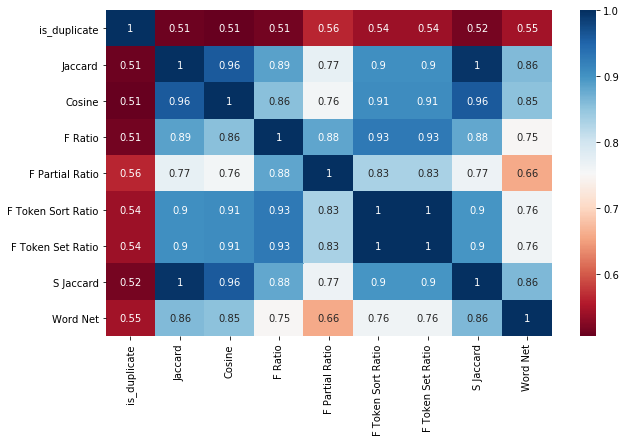

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(d.drop(['question1', 'question2'], axis=1).corr(), ax=ax, annot=True, cmap='RdBu')